In [2]:
# !pip install -q kagglehub numpy pandas networkx matplotlib torch torch-geometric==2.4.0 torch-geometric-temporal

In [3]:
# !pip install -q torch-geometric==2.6.1

In [1]:
%cd NYSE-Temporal-Graph-Construction

/teamspace/studios/this_studio/NYSE-Temporal-Graph-Construction


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import networkx as nx
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from os.path import join as join_path
import os
from torch.utils.data import Dataset
import kagglehub
import pandas as pd
from torch_geometric_temporal import DynamicGraphTemporalSignal, Data
from functools import cache
import torch
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [3]:
TARGET_GRAPH_DIR = "graph_data/train/infotech_thresh1"
TARGET_SECTORS = ['Information Technology']
FILTER_BY_WEIGHT_THRESH = 5
TRAINING_EPOCHS = 50
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
EMBED_DIM = 32

## Node features

In [4]:
dataset_path = kagglehub.dataset_download("dgawlik/nyse")

In [5]:
fundamentals_df = pd.read_csv(join_path(dataset_path,"fundamentals.csv"))
prices_split_adjusted_df = pd.read_csv(join_path(dataset_path, "prices-split-adjusted.csv"))
prices_df = pd.read_csv(join_path(dataset_path, "prices.csv"))
securities_df = pd.read_csv(join_path(dataset_path, "securities.csv"))

In [6]:
all_symbols = prices_split_adjusted_df['symbol'].sort_values().unique()

def get_symbol_by_sector(sector):
    return securities_df[securities_df['GICS Sector'] == sector]['Ticker symbol'].to_list()

target_symbols = prices_split_adjusted_df['symbol'].sort_values().unique()

target_symbols = []
for sector in TARGET_SECTORS:
    target_symbols += get_symbol_by_sector(sector)

target_symbols.sort()
    
@cache
def symbol_to_int(symbol: str):
    if symbol not in target_symbols:
        return -1
    return target_symbols.index(symbol)

@cache
def int_to_symbol(idx):
    idx = int(idx)
    return target_symbols[idx]


print("Num of all symbols:", len(all_symbols))
print("Num of target symbols:", len(target_symbols))

Num of all symbols: 501
Num of target symbols: 68


In [7]:
prices_split_adjusted_df['date'] = pd.to_datetime(prices_split_adjusted_df['date']).dt.date
dates = prices_split_adjusted_df['date'].sort_values().unique()

@cache
def any_to_date(date):
    if not isinstance(date, pd._libs.tslibs.timestamps.Timestamp):
        date = pd.to_datetime(date).date()
    return date

@cache
def date_to_int(date):
    date = any_to_date(date)
    return dates.tolist().index(date)

@cache
def int_to_date(idx):
    return dates[idx]

print(dates)

[datetime.date(2010, 1, 4) datetime.date(2010, 1, 5)
 datetime.date(2010, 1, 6) ... datetime.date(2016, 12, 28)
 datetime.date(2016, 12, 29) datetime.date(2016, 12, 30)]


<Axes: ylabel='Frequency'>

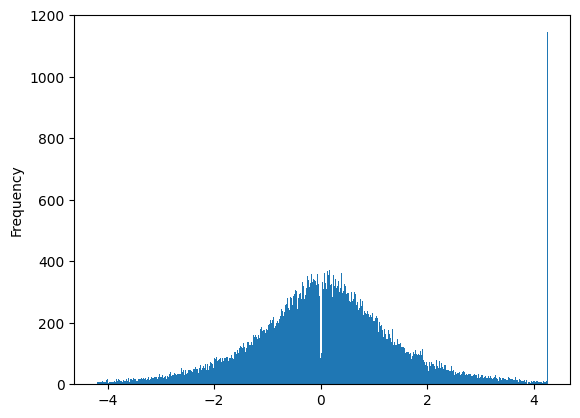

In [8]:
node_features_df = prices_split_adjusted_df.copy()
node_features_df = node_features_df[node_features_df['symbol'].isin(target_symbols)]
node_features_df['day_diff'] = ((node_features_df['close']) - (o:=node_features_df['open'])) / o * 100
node_features_df['date'] = node_features_df['date'].apply(lambda x: date_to_int(x))
node_features_df['symbol'] = node_features_df['symbol'].apply(lambda x: symbol_to_int(x))

# Drop rows with symbol -1:
node_features_df = node_features_df[node_features_df['symbol'] != -1]

# rename symbol to node_id
node_features_df = node_features_df.rename(columns={'symbol': 'node', 'date': 'time'})

lower_bound = node_features_df['day_diff'].quantile(0.01)  # 1st percentile
upper_bound = node_features_df['day_diff'].quantile(0.99)  # 99th percentile

node_features_df['day_diff'] = node_features_df['day_diff'].clip(lower=lower_bound, upper=upper_bound)



node_features_df.sort_values(['time', 'node'], inplace=True)
# node_features_df.head(10)
node_features_df['day_diff'].describe()
node_features_df['day_diff'].plot.hist(bins=1000)


## Graph

In [9]:
get_date = lambda filename: filename.split("_")[1].removesuffix(".edgelist")
get_nx_graph = lambda fileName: nx.read_weighted_edgelist(join_path(TARGET_GRAPH_DIR, fileName))

nx_graph_snapshots = [(get_date(fileName), get_nx_graph(fileName)) for fileName in os.listdir(TARGET_GRAPH_DIR)]

In [10]:
print("Total num of graphs:", len(nx_graph_snapshots))
print("Total num of edges:", sum([graph.number_of_edges() for _, graph in nx_graph_snapshots]))

Total num of graphs: 1233
Total num of edges: 2438163


In [11]:
torch_graphs = []
for date, nx_graph in nx_graph_snapshots:
    time = date_to_int(date)
    
    today_node_features_df = node_features_df[node_features_df['time'] == time].set_index('node', inplace=False)

    tomorrow_node_features_df = node_features_df[node_features_df['time'] == time + 1].set_index('node', inplace=False)

    today_node_features_df = today_node_features_df.reindex(range(len(target_symbols)), fill_value=0.0)
    tomorrow_node_features_df = tomorrow_node_features_df.reindex(range(len(target_symbols)), fill_value=0.0)
    
    today_node_features_df = today_node_features_df.drop(columns=['time'])

    y = tomorrow_node_features_df['day_diff'].values
    y = torch.tensor(y, device=device, dtype=torch.float)

    # convert to torch
    edges_data = pd.DataFrame.from_dict(nx_graph.edges.data())

    edges_data[0] = edges_data[0].apply(symbol_to_int)
    edges_data[1] = edges_data[1].apply(symbol_to_int)
    edges_data[2] = edges_data[2].apply(lambda x: x['weight'])

    # Filter by weight
    edges_data = edges_data[edges_data[2] > FILTER_BY_WEIGHT_THRESH]

    x = torch.tensor(today_node_features_df.values, dtype=torch.float32, device=device)
    
    edge_index = edges_data.loc[:,0:1].values
    edge_index = torch.tensor(edge_index, dtype=torch.long, device=device).t().contiguous()

    edge_weight = edges_data.loc[:,2].values
    edge_weight = torch.tensor(edge_weight, dtype=torch.float, device=device)

    torch_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    torch_graphs.append(torch_graph)

In [12]:
print(torch_graphs[0].y)

tensor([-0.1025,  0.5463,  1.7819, -0.1579, -0.1172,  0.3191, -1.3271,  2.8516,
        -0.3511, -1.9403,  0.7117,  0.2638,  1.0587,  0.0672, -0.0813,  0.0000,
         1.0893,  0.2104,  1.9115, -0.5885,  0.0000, -1.4264,  3.5431,  0.7919,
         0.0918,  1.4546, -1.1083, -0.5086, -0.5086,  0.1143,  0.0000,  1.0165,
        -0.7239, -0.6303, -0.3343,  0.1625, -1.5096, -0.9227, -0.1612, -0.4524,
        -0.6826, -1.7112,  0.3566, -1.1321,  2.8545, -3.8454, -1.4956,  1.8458,
         0.4045, -0.1621,  0.0000,  1.1574,  0.0000, -0.6416, -1.8028,  1.0745,
        -0.5435,  0.3237, -1.2019,  0.1163, -0.3468, -0.1947,  0.8471,  2.4476,
        -0.7311, -1.0659,  0.1159,  0.0581], device='cuda:0')


## Dataset

In [13]:
print("Graphs len:", len(torch_graphs))
# print("Node features len:", len(torch_node_features))

Graphs len: 1233


In [14]:
# dataset = DynamicGraphTemporalSignal(
#     [tg.edge_index for tg in torch_graphs],
#     [tg.edge_attr for tg in torch_graphs],
#     [tg.x for tg in torch_graphs],
#     [tg.y for tg in torch_graphs],
# )

In [15]:

from torch_geometric.loader import DataLoader

class NYSEDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, window_size=2):
        self.graphs = graphs
        self.window_size = window_size

    def __len__(self):
        return len(self.graphs) - self.window_size

    def __getitem__(self, idx):
        if idx >= len(self):
            raise StopIteration
        if idx < 0:
            idx = len(self) + idx
        return self.graphs[idx:idx + self.window_size]  # 3 snapshots


dataset = NYSEDataset(torch_graphs)
loader = DataLoader(dataset, batch_size=32,shuffle=True)

next(iter(loader))

[DataBatch(x=[2176, 6], edge_index=[2, 23037], edge_attr=[23037], y=[2176], batch=[2176], ptr=[33]),
 DataBatch(x=[2176, 6], edge_index=[2, 23247], edge_attr=[23247], y=[2176], batch=[2176], ptr=[33])]

In [16]:
from torch_geometric_temporal.nn.recurrent import GConvGRU, GCLSTM
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCN, GCNConv


class GraphEmbedder(GCN):
    """Embedder to extract node embeddings from a graph snapshot."""
    def __init__(self, input_dim, embed_dim):
        super(GraphEmbedder, self).__init__(input_dim, embed_dim, 1, embed_dim)
        # super(GraphEmbedder, self).__init__()
        # self.gcn1 = GCN(input_dim, embed_dim,)
        # # self.gcn2 = GCNConv(embed_dim, embed_dim)

    # def forward(self, x, edge_index, edge_weight=None):
    #     print(x.shape, edge_index.shape, edge_weight.shape)
    #     x = self.gcn1(x, edge_index, edge_weight)
    #     # x = torch.relu(x)
    #     # x = self.gcn2(x, edge_index, edge_weight)
    #     return x  # Returns node embeddings

class GraphRecEncoder(nn.Module):
    """Recurrent module to update node embeddings."""
    def __init__(self, input_dim, output_dim):
        super(GraphRecEncoder, self).__init__()
        self.gru = nn.GRUCell(input_dim, output_dim)

    def forward(self, embeddings, hidden_state=None):
        if hidden_state is None:
            hidden_state = torch.zeros_like(embeddings)
        new_state = self.gru(embeddings, hidden_state)
        return new_state  # Updated embeddings (new hidden state)

class GraphDecoder(nn.Module):
    """Decoder to predict values based on final node embeddings."""
    def __init__(self, embed_dim):
        super(GraphDecoder, self).__init__()
        self.fc1 = nn.Linear(embed_dim, embed_dim*2)
        self.fc2 = nn.Linear(embed_dim*2, embed_dim)
        self.fc3 = nn.Linear(embed_dim, 1)

    def forward(self, embeddings):
        x = torch.relu(self.fc1(embeddings))
        x = self.fc2(x)
        x = self.fc3(x)
        return x  # Prediction for each node

class Predictor(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, input_dim=6):
        super(Predictor, self).__init__()
        # self.embedder = GCN(input_dim, embed_dim, 1, embed_dim)
        # self.encoder = GraphRecEncoder(embed_dim, embed_dim)
        self.recurrent = GConvGRU(input_dim, embed_dim, 10)
        self.decoder = GraphDecoder(embed_dim)

    def forward(self, snapshots):
        prev_emb = None
        for graph in snapshots:
            # emb = self.embedder(graph.x, graph.edge_index, graph.edge_attr)
            # emb = self.encoder(emb, prev_emb) # Recurrent
            # prev_emb = emb
            prev_emb = self.recurrent(graph.x, graph.edge_index, graph.edge_attr, prev_emb)
            
        return self.decoder(prev_emb)



print("Arch:\n",_m:=Predictor())
print("Num params:", sum(p.numel() for p in _m.parameters()))


Arch:
 Predictor(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(6, 32, K=10, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=10, normalization=sym)
    (conv_x_r): ChebConv(6, 32, K=10, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=10, normalization=sym)
    (conv_x_h): ChebConv(6, 32, K=10, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=10, normalization=sym)
  )
  (decoder): GraphDecoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=1, bias=True)
  )
)
Num params: 40897


## Training

In [ ]:
model = Predictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()


TRAINING_EPOCHS = 1000
for epoch in range(TRAINING_EPOCHS):
    total_loss = 0
    model.train(True)
    pbar = tqdm(dataset, desc="Epoch {}".format(epoch + 1))
    pbar.clear()
    for i,snapshots in enumerate(dataset):
        optimizer.zero_grad()
        pred = model(snapshots)
        true_y = snapshots[-1].y
        loss = criterion(pred.squeeze(), true_y)
    

        loss.backward()
        optimizer.step()
        for name, param in model.named_parameters():
            if param.grad is None:
                print(f"No gradient for {name}")

        total_loss += loss.item()
        
        pbar.set_postfix(loss=loss.item(), total_loss=total_loss)
        if (i + 1) % 10 == 0:
            pbar.update(10)

    pbar.close()
    
    torch.save(model.state_dict(), f"weights/temporal_link_prediction_e{epoch+1}_model.pt")

torch.save(model.state_dict(), "weights/temporal_link_prediction_last_model.pt")

    

Epoch 1:  11%|█▏        | 140/1231 [00:57<07:25,  2.45it/s, loss=1.93, total_loss=258]

                                              

Epoch 9: 100%|█████████▉| 1230/1231 [01:17<00:00, 16.67it/s, loss=0.8, total_loss=2.5e+3]   

In [ ]:
# Load model
model = Predictor().to(device)
model.load_state_dict(torch.load("temporal_link_prediction_e10_model.pt"))

dict(model.named_parameters())
d = dataset[100]
print(model(d).unique().shape)
print(model(d).squeeze())
print(d[-1].y)
    

torch.Size([60])
tensor([-0.0748,  0.0994,  0.1127,  0.0637,  0.1005,  0.0991,  0.0963,  0.0241,
         0.0261,  0.0941, -0.0601,  0.0280,  0.0003, -0.0086,  0.0227,  0.0011,
         0.0420, -0.0430,  0.0222,  0.1496,  0.0222,  0.0320,  0.1129,  0.0516,
         0.0222,  0.0558,  0.0874, -0.0101,  0.1060,  0.0245,  0.0011,  0.0500,
         0.0742,  0.0662, -0.0256,  0.0994,  0.0442,  0.0046,  0.0654,  0.0678,
         0.0226,  0.0847, -0.0103,  0.0419,  0.0402,  0.0163,  0.0024,  0.0222,
         0.0192, -0.0010,  0.0011, -0.0103,  0.0011, -0.0152,  0.0214,  0.0461,
         0.0416, -0.0152,  0.0431,  0.0522,  0.0298,  0.0096,  0.0861,  0.1085,
         0.0566,  0.0823, -0.0420,  0.0074], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([-0.4906, -0.6731, -1.5615,  0.1577,  0.2718, -2.3323, -0.6586, -1.1814,
         0.6359,  0.1990,  4.1646, -1.3875, -0.0678, -2.4753,  0.6602,  0.0000,
         0.1704,  1.6396,  4.2580, -0.4919, -2.3481, -2.0386, -0.4448,  0.2926,
      

Epoch 1:  11%|█▏        | 140/1231 [00:29<01:16, 14.31it/s, loss=1.93, total_loss=258]

In [15]:
import torch
import torch.nn.functional as F

from torch_geometric_temporal.nn.recurrent import GCLSTM

class RecurrentGCN(torch.nn.Module):

    def __init__(self, node_features, num_classes):
        super(RecurrentGCN, self).__init__()
        self.recurrent_1 = GCLSTM(node_features, 32, 5)
        self.recurrent_2 = GCLSTM(32, 16, 5)
        self.linear = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.recurrent_1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.recurrent_2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)
